# Training exploration

In [3]:
from glob import glob
import pickle

import pandas as pd
from rankit.Table import Table
from rankit.Ranker import EloRanker

In [12]:
files = sorted(glob("../training/*.pkl"), reverse=True)
with open(files[0], 'rb') as f:
    state = pickle.load(f)

In [15]:
from tabulate import tabulate

def scores_table(self):
    return tabulate(
        [(player.name, score) for player, score in self.get_scores()],
        headers=["Player", "Score"],
        tablefmt="github",
    )

for i, gen in enumerate(state.training_gens):
    print(f"### Training gen {gen.child_gen} from {gen.source_gen}. Tournament results:")
    print(scores_table(gen.tournament))
    print("")


### Training gen 1 from 0. Tournament results:
| Player   |   Score |
|----------|---------|
| gen1     |      46 |
| uniform  |      41 |
| random   |      33 |

### Training gen 2 from 1. Tournament results:
| Player   |   Score |
|----------|---------|
| gen2     |   107.5 |
| gen1     |    45.5 |
| uniform  |    45   |
| random   |    42   |

### Training gen 3 from 2. Tournament results:
| Player   |   Score |
|----------|---------|
| gen2     |   129   |
| gen3     |   113   |
| gen1     |    70.5 |
| random   |    52.5 |
| uniform  |    35   |

### Training gen 4 from 2. Tournament results:
| Player   |   Score |
|----------|---------|
| gen4     |   135   |
| gen2     |    94   |
| gen3     |    92.5 |
| gen1     |    48   |
| random   |    30.5 |

### Training gen 5 from 4. Tournament results:
| Player   |   Score |
|----------|---------|
| gen2     |     100 |
| gen4     |     100 |
| gen3     |     100 |
| gen5     |      70 |
| gen1     |      30 |

### Training gen 6 from 

In [25]:
# Total training positions
tot = sum(len(gen.training_data) for gen in state.training_gens)
print(f"Total training positions: {tot}")

Total training positions: 2361492


In [9]:
# Model overall ranks based on tournament performance

df = pd.DataFrame.from_records(
    {
        "p0": game.p0.name,
        "p1": game.p1.name,
        "p0score": game.score,
        "p1score": 1 - game.score,
    }
    for gen in state.training_gens
    for game in gen.tournament.games
)
table = Table(df, col=["p0", "p1", "p0score", "p1score"])

eloRanker = EloRanker()
eloRanker.update(table)
eloRank = eloRanker.leaderboard()
print(eloRank.to_markdown())

|    | name    |   rating |   rank |
|---:|:--------|---------:|-------:|
|  0 | gen20   |  1811.67 |      1 |
|  1 | gen4    |  1594.95 |      2 |
|  2 | gen15   |  1563.46 |      3 |
|  3 | gen11   |  1557.35 |      4 |
|  4 | gen22   |  1546.2  |      5 |
|  5 | gen12   |  1543.55 |      6 |
|  6 | gen14   |  1543.14 |      7 |
|  7 | gen13   |  1541.27 |      8 |
|  8 | gen16   |  1532.4  |      9 |
|  9 | gen17   |  1516.62 |     10 |
| 10 | gen10   |  1513.8  |     11 |
| 11 | gen18   |  1510.89 |     12 |
| 12 | gen2    |  1503.38 |     13 |
| 13 | gen19   |  1500.64 |     14 |
| 14 | gen8    |  1496.41 |     15 |
| 15 | gen7    |  1487.36 |     16 |
| 16 | gen6    |  1464.17 |     17 |
| 17 | gen5    |  1443.68 |     18 |
| 18 | gen3    |  1417.44 |     19 |
| 19 | gen21   |  1393.73 |     20 |
| 20 | gen1    |  1385.84 |     21 |
| 21 | uniform |  1385.49 |     22 |
| 22 | gen9    |  1378.7  |     23 |
| 23 | random  |  1367.88 |     24 |


/home/advait/.cache/pypoetry/virtualenvs/c4a0---kqV2Mp-py3.11/lib/python3.11/site-packages/rankit/Table/Table.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table = pd.concat([self.table, table.table], ignore_index=True)


/home/advait/.cache/pypoetry/virtualenvs/c4a0---kqV2Mp-py3.11/lib/python3.11/site-packages/rankit/Table/Table.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.table = pd.concat([self.table, t], ignore_index=True)


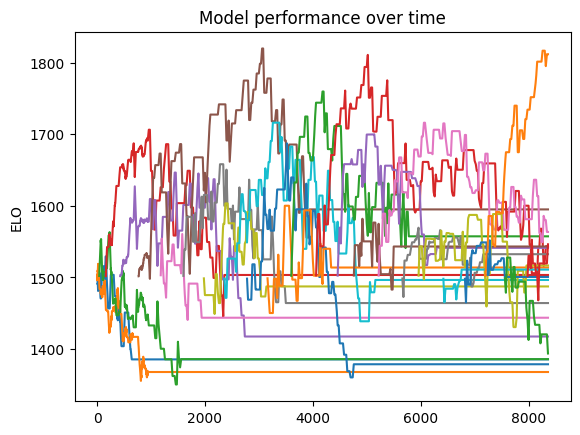

In [61]:
# Graph of ELO over time
from collections import defaultdict
import matplotlib.pyplot as plt

running_elos = defaultdict(list)
elo_ranker = EloRanker()

for game_idx, row in df.iterrows():
    elo_ranker.update_single(row.p0, row.p1, row.p0score, row.p1score)
    board = elo_ranker.leaderboard()
    for _, name, rating in board.loc[:, ["name", "rating"]].itertuples():
        running_elos[name].append((game_idx, rating))

for name, elos in running_elos.items():
    plt.plot(*zip(*elos), label=name)

plt.xlabel("Game")
plt.ylabel("ELO")
plt.title("Model performance over time")
plt.legend()
plt.show()